# Importing required libraries and datasets

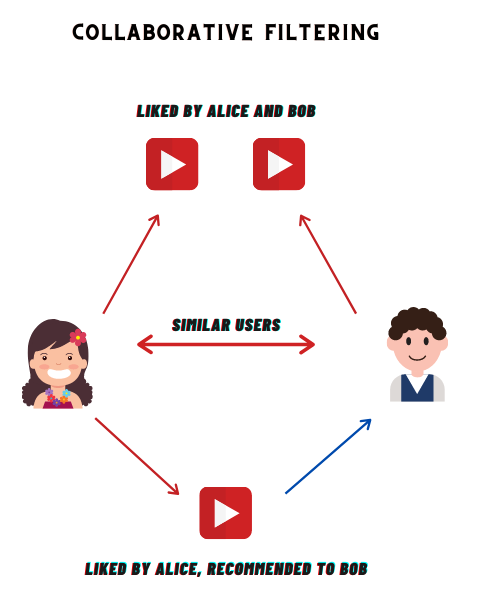

In [77]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [78]:
movies_meta = pd.read_csv('data/movies_metadata.csv',
                          usecols = ['id','imdb_id','title'])

movies_meta.head(2)

,id,imdb_id,title
0,862,tt0114709,Toy Story
1,8844,tt0113497,Jumanji


In [79]:
links = pd.read_csv('data/links.csv')

links.head(2)

,movieId,imdbId,tmdbId
0,1,114709,862.000
1,2,113497,8844.000


In [80]:
ratings_small = pd.read_csv('data/ratings_small.csv')

ratings_small.head()

,userId,movieId,rating,timestamp
0,1,31,2.500,1260759144
1,1,1029,3.000,1260759179
2,1,1061,3.000,1260759182
3,1,1129,2.000,1260759185
4,1,1172,4.000,1260759205


In [81]:
links  = links.merge(ratings_small, on = 'movieId')

links.head(2)

,movieId,imdbId,tmdbId,userId,rating,timestamp
0,1,114709,862.000,7,3.000,851866703
1,1,114709,862.000,9,4.000,938629179


In [82]:
links.rename(columns = {'tmdbId':'id'}, inplace = True)

In [83]:
movies_meta = movies_meta.drop([29503,35587,19730])

In [84]:
movies_meta['id'] = movies_meta['id'].astype('int64')

In [85]:
movies_meta = movies_meta.merge(links,on='id')

In [86]:
df = movies_meta[['userId', 'movieId', 'rating', 'title']]

df.head(3)

,userId,movieId,rating,title
0,7,1,3.000,Toy Story
1,9,1,4.000,Toy Story
2,13,1,5.000,Toy Story


In [87]:
combine_movie_rating = df.dropna(axis = 0, subset = ['title'])

movie_ratingCount = (df.
                     groupby(by = ['title'])['rating'].
                     count().
                     reset_index().
                     rename(columns = {'rating': 'totalRatingCount'})
                     [['title', 'totalRatingCount']])

movie_ratingCount.head()

,title,totalRatingCount
0,$9.99,3
1,'Neath the Arizona Skies,1
2,"'night, Mother",3
3,(500) Days of Summer,45
4,...And God Created Woman,1


In [88]:
rating_with_totalRatingCount = combine_movie_rating.merge(movie_ratingCount, left_on = 'title', right_on = 'title', how = 'left')

rating_with_totalRatingCount.head()

,userId,movieId,rating,title,totalRatingCount
0,7,1,3.000,Toy Story,247
1,9,1,4.000,Toy Story,247
2,13,1,5.000,Toy Story,247
3,15,1,2.000,Toy Story,247
4,19,1,3.000,Toy Story,247


In [89]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(movie_ratingCount['totalRatingCount'].describe())

count   8754.000
mean      11.406
std       24.549
min        1.000
25%        1.000
50%        3.000
75%       10.000
max      341.000
Name: totalRatingCount, dtype: float64


In [90]:
popularity_threshold = 50
rating_popular_movie= rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_movie.head()

,userId,movieId,rating,title,totalRatingCount
0,7,1,3.000,Toy Story,247
1,9,1,4.000,Toy Story,247
2,13,1,5.000,Toy Story,247
3,15,1,2.000,Toy Story,247
4,19,1,3.000,Toy Story,247


In [91]:
movie_features_df = rating_popular_movie.pivot_table(index='title', columns='userId', values='rating').fillna(0)
movie_features_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000
12 Angry Men,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2001: A Space Odyssey,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,...,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
28 Days Later,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
300,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [92]:
from scipy.sparse import csr_matrix

# converting the matrix into array matrix
movie_features_df_matrix = csr_matrix(movie_features_df.values)

# Model building

In [93]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')

model_knn.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

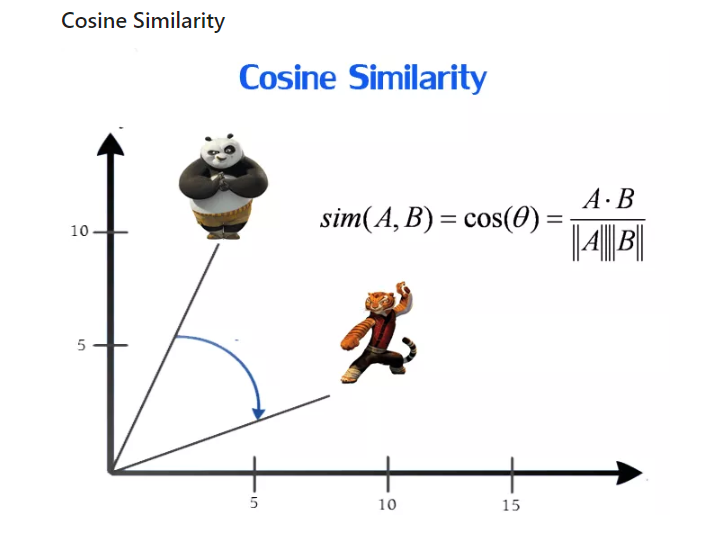

# Model Recommendation

In [94]:
def recommend_movie(movie_name):
    
    distances, indices = model_knn.kneighbors(movie_features_df.loc[movie_name,:].values.reshape(1, -1),
                                              n_neighbors = 6)
    
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('Recommendations for', movie_name)
        else:
            print('{0}: {1}, with distance of {2}:'.format(i, movie_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

In [105]:
recommend_movie('Avatar')

Recommendations for Avatar
1: Inception, with distance of 0.3663126779224054:
2: Iron Man, with distance of 0.36696298155661766:
3: The Dark Knight, with distance of 0.4246926245558492:
4: District 9, with distance of 0.43666774462351055:
5: Star Trek, with distance of 0.4385474244949342:


# Model Serialization

In [106]:
from pickle import dump

import bz2

In [110]:
dump(model_knn, open('models/model_knn.pkl', 'wb'))

dump(movie_features_df.to_dict(),open('models/collaborative_cosine_similarity.pkl','wb'))

# Model Deserialization

In [111]:
import numpy as np
from pickle import load

In [113]:
knn_model = load(open('models/model_knn.pkl', 'rb'))

In [114]:
knn_model

NearestNeighbors(algorithm='brute', metric='cosine')

In [115]:
df = load(open('models/collaborative_cosine_similarity.pkl', 'rb'))

In [116]:
df = pd.DataFrame(df)

In [117]:
df.head(1)

,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
10 Things I Hate About You,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000
